<a href="https://colab.research.google.com/github/ssandanshi/Speaker-Recognition/blob/master/CSC_591_G8_Speaker_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
!pip install python_speech_features

# Importing Libraries

In [0]:
import os
import glob
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import keras.backend as K
import keras
from python_speech_features import fbank, delta
import operator
from collections import OrderedDict
from multiprocessing import Pool
from time import time
import re
from sklearn.preprocessing import LabelEncoder

# Reading Data and Preprocessing

## Reading Data

In [0]:
# Constant to be used throughout the code
sample_rate = 12000

In [0]:
def read_audio(filename,sample_rate):
  audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
  return audio.flatten()

In [0]:
def normalize_frames(m,epsilon=1e-12):
    return [(v - np.mean(v)) / max(np.std(v),epsilon) for v in m]

In [0]:
def load_audio(filename, cnn=True):
  audio = read_audio(filename,sample_rate)
  # capture audio only from second 1 to second 5
  start_sec, end_sec = 1,5
  start_frame = int(start_sec * sample_rate)
  end_frame = int(end_sec * sample_rate)
  audio = audio[start_frame:end_frame]

  #Padding with zeros if audio length less than 4 secs
  if len(audio)<(end_frame-start_frame):
    au = [0]*(end_frame-start_frame)
    for i in range(len(audio)):
        au[i] = audio[i]
    audio = np.array(au)
  #print(len(audio),sample_rate)

  filter_banks, energies = fbank(audio, samplerate=sample_rate, nfilt=64, winlen=0.025) #filter_bank (num_frames , 64),energies (num_frames ,)
  #Standardize with mean and std
  filter_banks = normalize_frames(filter_banks)
  #print("filterbanks:" + str(len(filter_banks)))
  frames_features = filter_banks

  num_frames = len(frames_features)
  #print(num_frames)
  return np.reshape(np.array(frames_features),(num_frames, 64, 1))



In [0]:
'''
This function will read the data into a dataframe.
If the pattern is  .wav and flag is false, It will read the actual audio files (before preprocessing)
If flag is True and pattern is npy, It will read preprocessed files stored as npy (numpy arrays)
'''
def create_catalogue(path,pattern="*/*.wav",flag=False):
  data = pd.DataFrame()
  data['filename'] = glob.glob(os.path.join(path, pattern), recursive=True)
  if not flag:
    data['class'] = data['filename'].apply(lambda x: x.split("/")[1])
  else:
    data['class'] = data['filename'].apply(lambda x: x.split("/")[1].split('_')[0])
  num_speakers = len(data['class'].unique())
  print('Retrieved {} files with {} different speakers.'.format(str(len(data)), str(num_speakers)))
  # print(data.head(10))
  return data

In [0]:
#catalog = create_catalogue("subset3_npy","*.npy",True)

## Preprocessing

In [0]:
#Used to preprocess a batch of files using. To be run inside each thread of he Mutlpithread preprocess call.
def preprocess_batch(data,out_dir="subset2_npy",task_num="0"):
  start_time = time()
  i=0
  for i in range(len(data)):
    orig_time = time()
    filename = data.iloc[i]['filename']
    target_filename = out_dir+"/" + filename.split("/")[1]+"_"+filename.split("/")[-1].split('.')[0] + '.npy'
    
    if os.path.exists(target_filename):
      if i % 10 == 0: print("Task ID:{0} File No.: {1} Existing File Name:{2}".format(task_num, i, filename))
      continue
    feature = load_audio(filename)
    #print('!!!',feature.ndim,feature.shape[0],feature.shape[1],feature.shape[2])
    if feature.ndim != 3 or feature.shape[0] < 399 or feature.shape[1] !=64 or feature.shape[2] != 1:
      print('Error in loading file:',filename)
      continue
    np.save(target_filename, feature)
    if i % 100 == 0:
      print("Task ID:{0} Time taken per file: {1:.3f}s Current File No.:{2} File name:{3}".format(task_num, time() - orig_time, i, filename))
  print("Task ID {} with {} files completed in {} seconds.".format(task_num, i, time()-start_time))

In [0]:
#Master preprocessing function. Runs 10 threads in parralel to perform Feature Preprocessing.
def preprocess(data_dir,out_dir):
  orig_time = time()
  data = create_catalogue(data_dir)
  print("STARTING PREPROCESSING")
  print("Starting 10 threads to exttra ct audio, feature banks and store as npy files.")
  p = Pool(10)
  print(len(data))
  patch = int(len(data)/10)
  for i in range(10):
      if i < 9:
          sdata=data[i*patch: (i+1)*patch]
      else:
          #Last patch gets leftover data
          sdata = data[i*patch:]
      p.apply_async(preprocess_batch, args=(sdata,out_dir,i))
  print('Waiting for all subprocesses done...')
  p.close()
  p.join()

  print("Preprocessing Finished. Took {} seconds".format(time()-orig_time))

### Running the preprocessing on original data. We have shared the output of this in form of npy files in order to save computation time

In [0]:
#preprocess("subset2","subset3_npy")
#!zip -rq subset3_npy.zip subset3_npy
#!cp subset3_npy.zip drive/My\ Drive

Reading saved npy files from google drive

In [0]:
# !cp drive/My\ Drive/subset3_npy.zip .
# !unzip -q subset3_npy.zip

In [142]:
catalog = create_catalogue("subset3_npy","*.npy",True)

Retrieved 44998 files with 300 different speakers.


# Training Triplet Loss

In [0]:
NUM_FRAMES=399
BATCH_SIZE=32
TRIPLET_PER_BATCH=3

## Creating Mini Batches
refer to report for details

In [0]:
def clipped_audio(x, num_frames=NUM_FRAMES):
    if x.shape[0] > num_frames:
        bias = np.random.randint(0, x.shape[0] - num_frames)
        clipped_x = x[bias: num_frames + bias]
    else:
        clipped_x = x

    return clipped_x


class MiniBatch:
    def __init__(self, data, batch_size, unique_speakers=None):    
        if unique_speakers is None:
            unique_speakers = list(data['class'].unique())
        num_triplets = batch_size

        anchor_batch = None
        positive_batch = None
        negative_batch = None
        for ii in range(num_triplets):
            two_different_speakers = np.random.choice(unique_speakers, size=2, replace=False)
            anchor_positive_speaker = two_different_speakers[0]
            negative_speaker = two_different_speakers[1]
            #print(two_different_speakers)
            anchor_positive_file = data[data['class'] == anchor_positive_speaker].sample(n=2, replace=False)
            anchor_df = pd.DataFrame(anchor_positive_file[0:1])
            anchor_df['training_type'] = 'anchor'
            positive_df = pd.DataFrame(anchor_positive_file[1:2])
            positive_df['training_type'] = 'positive'
            negative_df = data[data['class'] == negative_speaker].sample(n=1)
            negative_df['training_type'] = 'negative'

            if anchor_batch is None:
                anchor_batch = anchor_df.copy()
            else:
                anchor_batch = pd.concat([anchor_batch, anchor_df], axis=0)
            if positive_batch is None:
                positive_batch = positive_df.copy()
            else:
                positive_batch = pd.concat([positive_batch, positive_df], axis=0)
            if negative_batch is None:
                negative_batch = negative_df.copy()
            else:
                negative_batch = pd.concat([negative_batch, negative_df], axis=0)

        self.data_batch = pd.DataFrame(pd.concat([anchor_batch, positive_batch, negative_batch], axis=0))
        self.num_triplets = num_triplets

    def to_inputs(self,le=None):

        new_x = []
        for i in range(len(self.data_batch)):
            filename = self.data_batch.iloc[i]['filename']
            x = np.load(filename)
            new_x.append(x)
        x = np.array(new_x) #(batchsize, num_frames, 64, 1)
        y = self.data_batch['class'].values
        if le is not None:
          y = le.transform(y)
          no_of_speakers = len(le.classes_)
          y = np.eye(no_of_speakers)[y_]    #one-hot

        # anchor examples [speakers] == positive examples [speakers]
        np.testing.assert_array_equal(y[0:self.num_triplets], y[self.num_triplets:2 * self.num_triplets])
        return x, y


def stochastic_mini_batch(data, batch_size=BATCH_SIZE,unique_speakers=None):
    mini_batch = MiniBatch(data, batch_size,unique_speakers)
    return mini_batch

In [145]:
data_npy = create_catalogue("subset3_npy","*.npy",flag=True) 
unique_speakers = data_npy["class"].unique()
batch = stochastic_mini_batch(data_npy, batch_size=BATCH_SIZE, unique_speakers=unique_speakers)
batch_size = BATCH_SIZE * TRIPLET_PER_BATCH
x, y = batch.to_inputs()

Retrieved 44998 files with 300 different speakers.


In [0]:
# finding input shape
audio_file = x[0]
num_frames = audio_file.shape[0]
train_batch_size = batch_size
#batch_shape = [batch_size * num_frames] + list(audio_file.shape[1:])  # A triplet has 3 parts.
input_shape = (num_frames, audio_file.shape[1], audio_file.shape[2])

# Pretraining Input Generator

In [147]:
le = LabelEncoder()
le.fit(data_npy["class"])

LabelEncoder()

### Loading Mini batches 
used to load train and test data as iterators/generators.

In [0]:
def load_from_list(x_paths, batch_start, limit, le):
    x = []
    y_ = []
    for i in range(batch_start, limit):
        x.append(np.load(x_paths[i]))
        y_.append(x_paths[i].split("/")[-1].split("_")[0])
    y_ = le.transform(y_)
    no_of_speakers = len(le.classes_)
    x = np.asarray(x)
    y = np.eye(no_of_speakers)[y_]    #one hot encoding
    y = np.asarray(y)
    return x, y

In [0]:
def batch_training_data_generator(paths, le, batch_size=BATCH_SIZE * TRIPLET_PER_BATCH):
  L = len(paths)
  while True:
    np.random.shuffle(paths)
    batch_start = 0
    batch_end = batch_size

    while batch_end < L:
      x_train_t, y_train_t = load_from_list(paths, batch_start, batch_end, le)
      randnum = random.randint(0, 100)
      random.seed(randnum)
      random.shuffle(x_train_t)
      random.seed(randnum)
      random.shuffle(y_train_t)
      yield (x_train_t, y_train_t)
      batch_start += batch_size
      batch_end += batch_size


In [0]:
def batch_test_data_generator(paths, le, batch_size=BATCH_SIZE * TRIPLET_PER_BATCH):
  L = len(paths)
  while True:
    np.random.shuffle(paths)
    batch_start = 0
    batch_end = batch_size

    while batch_end < L:
      x_test_t, y_test_t = load_from_list(paths, batch_start, batch_end, le)
      yield (x_test_t, y_test_t)
      batch_start += batch_size
      batch_end += batch_size

In [0]:
def split_data(files, labels, batch_size):
  test_size = max(batch_size/len(labels),0.05)
  train_paths, test_paths, y_train, y_test = train_test_split(files, labels, test_size=test_size, random_state=42)
  return np.array(train_paths), np.array(test_paths)

# CNN Model

In [0]:
import keras.backend as K
import math
from keras import layers
from keras import regularizers
from keras.layers import Input, GRU
from keras.layers.convolutional import Conv2D
from keras.layers.core import Lambda, Dense, RepeatVector
from keras.layers.core import Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import tensorflow as tf

In [0]:
#restrictting input to range (0,20) - Clipping the ReLU
def clipped_relu(inputs):
    return Lambda(lambda y: K.minimum(K.maximum(y, 0), 20))(inputs)

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    conv_name_base = 'res{}_{}_branch'.format(stage, block)

    x = Conv2D(filters,
                   kernel_size=kernel_size,
                   strides=1,
                   activation=None,
                   padding='same',
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(l=0.00001),
                   name=conv_name_base + '_2a')(input_tensor)
    x = BatchNormalization(name=conv_name_base + '_2a_bn')(x)
    x = clipped_relu(x)

    x = Conv2D(filters,
                   kernel_size=kernel_size,
                   strides=1,
                   activation=None,
                   padding='same',
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(l=0.00001),
                   name=conv_name_base + '_2b')(x)
    x = BatchNormalization(name=conv_name_base + '_2b_bn')(x)


    x = layers.add([x, input_tensor])
    x = clipped_relu(x)
    return x


In [0]:
def convolutional_model(input_shape=(NUM_FRAMES,64, 1),    #input_shape(32,32,3)
                        batch_size=BATCH_SIZE * TRIPLET_PER_BATCH , num_frames=NUM_FRAMES):
    # http://cs231n.github.io/convolutional-networks/
    # conv weights
    # #params = ks * ks * nb_filters * num_channels_input

    # Conv128-s
    # 5*5*128*128/2+128
    # ks*ks*nb_filters*channels/strides+bias(=nb_filters)

    # take 100 ms -> 4 frames.
    # if signal is 3 seconds, then take 100ms per 100ms and average out this network.
    # 8*8 = 64 features.

    # used to share all the layers across the inputs

    # num_frames = K.shape() - do it dynamically after.

    def conv_and_res_block(inp, filters, stage):
        conv_name = 'conv{}-s'.format(filters)
        o = Conv2D(filters,
                       kernel_size=5,
                       strides=2,
                       padding='same',
                       kernel_initializer='glorot_uniform',
                       kernel_regularizer=regularizers.l2(l=0.00001), name=conv_name)(inp)
        o = BatchNormalization(name=conv_name + '_bn')(o)
        o = clipped_relu(o)
        for i in range(3):
            o = identity_block(o, kernel_size=3, filters=filters, stage=stage, block=i)
        return o

    def cnn_component(inp):
        x_ = conv_and_res_block(inp, 64, stage=1)
        x_ = conv_and_res_block(x_, 128, stage=2)
        x_ = conv_and_res_block(x_, 256, stage=3)
        x_ = conv_and_res_block(x_, 512, stage=4)
        return x_

    inputs = Input(shape=input_shape)
    
    x = cnn_component(inputs)  # shape = (BATCH_SIZE , num_frames/16, 64/16, 512)
    
    x = Lambda(lambda y: K.reshape(y, (-1, math.ceil(num_frames/16), 2048)), name='reshape')(x)
    x = Lambda(lambda y: K.mean(y, axis=1), name='average')(x)  #shape = (BATCH_SIZE, 512)
    x = Dense(512, name='affine')(x)  # .shape = (BATCH_SIZE , 512)
    x = Lambda(lambda y: K.l2_normalize(y, axis=1), name='ln')(x)

    model = Model(inputs, x, name='convolutional')

    #print(model.summary())
    return model

In [0]:
def find_last_checkpoint_if_exists(checkpoint_folder):
  os.makedirs(checkpoint_folder, exist_ok=True)
  files = glob.glob('{}/*.h5'.format(checkpoint_folder), recursive=True)
  if len(files) == 0:
      return None
  return sort_filenames(files)[-1]

In [0]:
def create_dir_and_delete_content(directory):
  os.makedirs(directory, exist_ok=True)
  files = sorted(filter(lambda f: os.path.isfile(f) and f.endswith(".h5"), 
      map(lambda f: os.path.join(directory, f), os.listdir(directory))),
      key=os.path.getmtime)
  # delete all but most current file to assure the latest model is availabel even if process is killed
  for file in files[:-4]:
      print("removing old model: {}".format(file))
      os.remove(file)

In [0]:
#Sorting the file names
def sort_filenames(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [0]:
#calculating Triplet Loss
def triplet_loss(y_true, y_pred):
  elements = BATCH_SIZE
  anchor = y_pred[0:elements]
  positive_ex = y_pred[elements:2 * elements]
  negative_ex = y_pred[2 * elements:]

  sap = batch_cosine_similarity(anchor, positive_ex)
  san = batch_cosine_similarity(anchor, negative_ex)
  loss = K.maximum(san - sap + ALPHA, 0.0)
  total_loss = K.sum(loss)
  return total_loss

In [0]:
def batch_cosine_similarity(x1, x2):
  # https://en.wikipedia.org/wiki/Cosine_similarity
  # 1 = equal direction ; -1 = opposite direction
  dot = K.squeeze(K.batch_dot(x1, x2, axes=1), axis=1)
  return dot

# Pre-Training

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
NUM_NEGATIVE_TEST = 99
TEST_DIR = "subset3_npy"
CHECKPOINT_FOLDER = "drive/My Drive/MLSP2"
ALPHA = 0.2
batch_size = BATCH_SIZE * TRIPLET_PER_BATCH
SAVE_PER_EPOCHS=200
DATA_DIR = "subset3_npy"
TEST_DIR = "vox_test_npy"
TEST_PER_EPOCHS = 50
BEST_CHECKPOINT_FOLDER = "drive/My Drive/MLSP_BEST"

In [168]:
train_data, test_data = split_data(data_npy["filename"], data_npy["class"], batch_size)
train_batch_iterator = batch_training_data_generator(train_data,le, batch_size=batch_size)
test_batch_iterator = batch_test_data_generator(test_data, le, batch_size=batch_size)
test_steps = int(len(test_data)/batch_size)
x_test, y_test = test_batch_iterator.__next__()
audio_file = x_test[0]
num_frames = audio_file.shape[0]
print('Numer of Frames : {}'.format(num_frames))
print('Batch Size: {}'.format(batch_size))
no_of_speakers = len(le.classes_)
base_model = convolutional_model(input_shape=x_test.shape[1:], batch_size=batch_size, num_frames=num_frames)
x = base_model.output
x = Dense(no_of_speakers, activation='softmax',name='softmax_layer')(x)

model = Model(base_model.input, x)
print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Numer of Frames : 399
Batch Size: 96
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 399, 64, 1)   0                                            
__________________________________________________________________________________________________
conv64-s (Conv2D)               (None, 200, 32, 64)  1664        input_10[0][0]                   
__________________________________________________________________________________________________
conv64-s_bn (BatchNormalization (None, 200, 32, 64)  256         conv64-s[0][0]                   
__________________________________________________________________________________________________
lambda_253 (Lambda)             (None, 200, 32, 64)  0           conv64-s_bn[0][0]                
_______________________________________________________

In [0]:
PRE_CHECKPOINT_FOLDER = 'drive/My Drive/MLSP_PRE'

In [0]:
import random

In [171]:
grad_steps = 0
# last_checkpoint = find_last_checkpoint_if_exists(PRE_CHECKPOINT_FOLDER)
# last_checkpoint = None
last_checkpoint = 'drive/My Drive/model_8000_1.72135.h5'
if last_checkpoint is not None:
    print('Found checkpoint [{}]. Resume from here...'.format(last_checkpoint))
    model.load_weights(last_checkpoint)
    grad_steps = int(last_checkpoint.split('_')[-2])

Found checkpoint [drive/My Drive/model_8000_1.72135.h5]. Resume from here...


In [172]:
while True:
    orig_time = time()
    # Gettting next batch from iterator
    x_train, y_train = train_batch_iterator.__next__()
    [loss, acc] = model.train_on_batch(x_train, y_train)  # return [loss, acc]
    print('Train Steps:{0}, Time:{1:.2f}s, Loss={2}, Accuracy={3}'.format(grad_steps,time() - orig_time, loss,acc))

    if grad_steps % TEST_PER_EPOCHS == 0:
        losses = []; accs = []
        for ss in range(test_steps):
            [loss, acc] = model.test_on_batch(x_test, y_test)
            x_test, y_test = test_batch_iterator.__next__()
            losses.append(loss); accs.append(acc)
        loss = np.mean(np.array(losses)); acc = np.mean(np.array(accs))
        print('Test the Data ---------- Steps:{0}, Loss={1}, Accuracy={2}, '.format(grad_steps,loss,acc))

    if grad_steps  % SAVE_PER_EPOCHS == 0:
        create_dir_and_delete_content(PRE_CHECKPOINT_FOLDER)
        model.save_weights('{0}/model_{1}_{2:.5f}.h5'.format(PRE_CHECKPOINT_FOLDER, grad_steps, loss))

    grad_steps += 1

Train Steps:8000, Time:16.23s, Loss=1.8429365158081055, Accuracy=0.6666666865348816


KeyboardInterrupt: ignored

# Training

In [173]:
data_npy = create_catalogue("subset3_npy","*.npy",flag=True) 
unique_speakers = data_npy["class"].unique()
batch = stochastic_mini_batch(data_npy, batch_size=BATCH_SIZE, unique_speakers=unique_speakers)
batch_size = BATCH_SIZE * TRIPLET_PER_BATCH
x, y = batch.to_inputs()

Retrieved 44998 files with 300 different speakers.


In [0]:
audio_file = x[0]
num_frames = audio_file.shape[0]
train_batch_size = batch_size
#batch_shape = [batch_size * num_frames] + list(audio_file.shape[1:])  # A triplet has 3 parts.
input_shape = (num_frames, audio_file.shape[1], audio_file.shape[2])

In [175]:
model = convolutional_model(input_shape=input_shape, batch_size=batch_size, num_frames=num_frames)
model.summary()

Model: "convolutional"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 399, 64, 1)   0                                            
__________________________________________________________________________________________________
conv64-s (Conv2D)               (None, 200, 32, 64)  1664        input_11[0][0]                   
__________________________________________________________________________________________________
conv64-s_bn (BatchNormalization (None, 200, 32, 64)  256         conv64-s[0][0]                   
__________________________________________________________________________________________________
lambda_281 (Lambda)             (None, 200, 32, 64)  0           conv64-s_bn[0][0]                
______________________________________________________________________________________

In [0]:
NUM_NEGATIVE_TEST = 99
TEST_DIR = "vox_test_npy"
CHECKPOINT_FOLDER = "drive/My Drive"
ALPHA = 0.2

## Loading Pre-training weights

In [177]:
last_checkpoint = find_last_checkpoint_if_exists(PRE_CHECKPOINT_FOLDER)
last_checkpoint = "drive/My Drive/model_8000_1.72135.h5"
if last_checkpoint is not None:
    print('Found pre-training checkpoint [{}]. Resume from here...'.format(last_checkpoint))
    x = model.output
    x = Dense(len(unique_speakers), activation='softmax', name='softmax_layer')(x)
    pre_model = Model(model.input, x)
    pre_model.load_weights(last_checkpoint)
    grad_steps = int(last_checkpoint.split('_')[-2])
    print('Successfully loaded pre-training model')

Found pre-training checkpoint [drive/My Drive/model_8000_1.72135.h5]. Resume from here...
Successfully loaded pre-training model


In [0]:
grad_steps=0

Loading Checkpoints for Pretraining + triplet Loss

In [179]:
# last_checkpoint = find_last_checkpoint_if_exists(CHECKPOINT_FOLDER)
last_checkpoint = "drive/My Drive/model_1152_0.21762_0.17803.h5"
if last_checkpoint is not None:
    print('Found checkpoint [{}]. Resume from here...'.format(last_checkpoint))
    model.load_weights(last_checkpoint)
    grad_steps = int(last_checkpoint.split('_')[-3])
    min_loss = float(last_checkpoint.split('_')[-2].split(".")[0])
else:
    min_loss = float('inf')

Found checkpoint [drive/My Drive/model_1152_0.21762_0.17803.h5]. Resume from here...


In [0]:
#adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss=triplet_loss)

In [0]:
from shutil import copyfile
import pickle

In [183]:
steps = 0
max_steps = 1000
hist_loss = {}
while steps<max_steps:
    steps+=1
    batch = stochastic_mini_batch(data_npy, batch_size=BATCH_SIZE, unique_speakers=unique_speakers)
    batch_size = BATCH_SIZE * TRIPLET_PER_BATCH
    x, _ = batch.to_inputs()
    y = np.random.uniform(size=(x.shape[0], 1))
    loss = model.train_on_batch(x, y)
    print("Step",grad_steps,loss)
    hist_loss[grad_steps]=loss
  
    #checkpoint to save weights
    if (grad_steps ) % SAVE_PER_EPOCHS == 0:
        create_dir_and_delete_content(CHECKPOINT_FOLDER)
        model.save_weights('{0}/model_{1}_{2:.5f}.h5'.format(CHECKPOINT_FOLDER, grad_steps, loss))
    grad_steps += 1

Step 1152 0.5489491
Step 1153 0.4757245
Step 1154 0.6082143
Step 1155 0.45742002
Step 1156 0.77682966
Step 1157 0.33235633


KeyboardInterrupt: ignored

# Testing Embeddings on test set

Using the 40 speaker test subset to train a SVC classifier on ttop of speaker embeddings

In [184]:
!cp drive/My\ Drive/vox_test_npy.zip .
!unzip -q vox_test_npy.zip

replace vox_test_npy/id10292_29.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [185]:
!ls

drive	     subset3_npy      train_loss_acc.txt  vox_test_npy.zip
sample_data  subset3_npy.zip  vox_test_npy


In [0]:
best_model_checkpoint = "drive/My Drive/model_1152_0.21762_0.17803.h5"
#best_model_checkpoint = "drive/My Drive/MLSP/model_4000_2.21986.h5"
if best_model_checkpoint is not None:
    model.load_weights(best_model_checkpoint)

In [187]:
test_catalog = create_catalogue("vox_test_npy","*.npy",flag=True)
test_catalog

Retrieved 4874 files with 40 different speakers.


,filename,class
0,vox_test_npy/id10289_26.npy,id10289
1,vox_test_npy/id10273_182.npy,id10273
2,vox_test_npy/id10275_66.npy,id10275
3,vox_test_npy/id10273_21.npy,id10273
4,vox_test_npy/id10271_67.npy,id10271
...,...,...
4869,vox_test_npy/id10307_151.npy,id10307
4870,vox_test_npy/id10305_42.npy,id10305
4871,vox_test_npy/id10298_19.npy,id10298
4872,vox_test_npy/id10309_27.npy,id10309


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le2 = LabelEncoder()
test_catalog["class"] = le2.fit_transform(test_catalog["class"])

In [190]:
le2.classes_

array(['id10270', 'id10271', 'id10272', 'id10273', 'id10274', 'id10275',
       'id10276', 'id10277', 'id10278', 'id10279', 'id10280', 'id10281',
       'id10282', 'id10283', 'id10284', 'id10285', 'id10286', 'id10287',
       'id10288', 'id10289', 'id10290', 'id10291', 'id10292', 'id10293',
       'id10294', 'id10295', 'id10296', 'id10297', 'id10298', 'id10299',
       'id10300', 'id10301', 'id10302', 'id10303', 'id10304', 'id10305',
       'id10306', 'id10307', 'id10308', 'id10309'], dtype=object)

In [0]:
def predict_model_batch(model,inp,batch_size=10):
  i = 0
  embedding = None
  while i < len(inp) and i+batch_size<len(inp):
    subset = inp[i:i+batch_size]
    sub_embed = model.predict_on_batch(subset)
    if embedding is None:
        embedding = sub_embed
    else:
        embedding = np.concatenate([embedding, sub_embed], axis=0)
    i+=batch_size
  if i<len(inp):
    subset = inp[i:]
    sub_embed = model.predict_on_batch(subset)
    if embedding is None:
        embedding = sub_embed
    else:
        embedding = np.concatenate([embedding, sub_embed], axis=0)
  return embedding

In [0]:
def split_balanced_and_load_data(data,samples_per_class,model=None,batch_size=10,top_classes=None,seed=999):
  if top_classes is None:
    classes = data["class"].unique()
  else:
    classes = data["class"].value_counts()[:top_classes].index.to_list()
    data = data[data["class"].isin(classes)]
  train = pd.DataFrame()
  removed_indices = []
  for cl in classes:
    data_class = data[data["class"]==cl]
    #distributing data evenly for classes with lesser utterances
    if samples_per_class<len(data_class)/2:
      sample = data_class.sample(samples_per_class,random_state=seed)
      removed_indices.extend(sample.index.to_list())
      train = pd.concat([train,sample], axis=0)
    else:
      sample = data_class.sample(int(len(data_class)/2),random_state=seed)
      removed_indices.extend(sample.index.to_list())
      train = pd.concat([train,sample], axis=0)
  test = data.loc[~data.index.isin(removed_indices)]
  train = train.reset_index(drop=True)
  test = test.reset_index(drop=True)
  trainX, trainY, testX, testY = np.array(train["filename"]),np.array(train["class"]),np.array(test["filename"]),np.array(test["class"])

  if model is not None:
    trainX = predict_model_batch(model,np.array([np.load(x) for x in trainX]),batch_size=batch_size)
    testX = predict_model_batch(model,np.array([np.load(x) for x in testX]),batch_size=batch_size)
  else:
    trainX = np.array([np.load(x) for x in trainX])
    testX = np.array([np.load(x) for x in testX])
    trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1]*trainX.shape[2]*trainX.shape[3]))
    testX = np.reshape(testX,(testX.shape[0],testX.shape[1]*testX.shape[2]*testX.shape[3]))
  return trainX, trainY, testX, testY




In [0]:
best_model = model
#change this for smaller samples
samples_per_class = 80
num_classes = len(test_catalog["class"].unique())
top_classes = None

In [0]:
trainX, trainY, testX, testY = split_balanced_and_load_data(test_catalog,samples_per_class,best_model,batch_size=20,top_classes=top_classes)

In [195]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(2168, 512) (2168,) (2706, 512) (2706,)


In [196]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(trainX,trainY)
y_pred = clf.predict(testX)
accuracy_score(testY,y_pred)

0.803030303030303

# Test Own Audio

We recorded ourselves speaking and computed the cosine similarity between same speaker and different speaker. We then compared the cosine similarity after feature embedding

In [0]:
!pip uninstall matplotlib
!pip install matplotlib==3.0.0

Uninstalling matplotlib-3.1.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/matplotlib-3.1.1-py3.6-nspkg.pth
    /usr/local/lib/python3.6/dist-packages/matplotlib-3.1.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/matplotlib/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.6/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.1.1
     |████████████████████████████████| 12.8MB 6.8MB/s 
ERROR: yellowbrick 0.9.1 has requirement matplotlib!=3.0.0,>=1.5.1, but you'll have matplotlib 3.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement matplotlib!=3.0.0,>=2.0.0, but you'll have matplotlib 3.0.0 which is incompat

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [0]:
!cp -r drive/My\ Drive/sample_audio .

In [0]:
!ls sample_audio/Sourabh

Recording_37.wav  Recording_38.wav  Recording_39.wav  Recording_40.wav


In [0]:
r1 = load_audio('sample_audio/Rachit/1.m4a')
r2 = load_audio('sample_audio/Rachit/2.m4a')
r3 = load_audio('sample_audio/Rachit/3.m4a')

In [0]:
#s1 = load_audio('sample_audio/Sourabh/Recording_37.wav')
s1 = load_audio('sample_audio/Sourabh/Recording_40.wav')
s2 = load_audio('sample_audio/Sourabh/Recording_38.wav')
s3 = load_audio('sample_audio/Sourabh/Recording_39.wav')

In [0]:
r1e, r2e, r3e = model.predict_on_batch(np.array([r1,r2,r3]))

In [0]:
s1e, s2e, s3e = model.predict_on_batch(np.array([s1,s2,s3]))

In [0]:
#cosine_similarity([np.reshape(r1,(r1.shape[0]*r1.shape[1]))],[np.reshape(r2,(r2.shape[0]*r2.shape[1]))])

In [0]:
cosine_similarity([r1e],[r2e])

array([[0.8589179]], dtype=float32)

In [0]:
embeds = [r1e,r2e,r3e,s1e,s2e,s3e]

In [0]:
mat = np.zeros((6,6))
for i in range(6):
  for j in range(6):
    mat[i][j] = cosine_similarity([embeds[i]],[embeds[j]])[0][0]

print(mat)
    


[[1.00000012 0.85891789 0.91493011 0.0729316  0.17969669 0.32267368]
 [0.85891789 1.         0.92580891 0.07299769 0.16040975 0.21139029]
 [0.91493011 0.92580891 1.00000024 0.18016392 0.2488142  0.37405908]
 [0.0729316  0.07299769 0.18016392 1.00000024 0.80381113 0.66639113]
 [0.17969669 0.16040975 0.2488142  0.80381113 1.         0.74625635]
 [0.32267368 0.21139029 0.37405908 0.66639113 0.74625635 1.        ]]


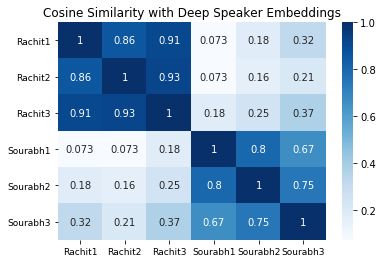

In [0]:
ax = sns.heatmap(mat,cmap="Blues",annot=True)
ax.set_yticklabels(np.array(['Rachit1','Rachit2','Rachit3','Sourabh1','Sourabh2','Sourabh3']),fontsize=9)
ax.set_xticklabels(np.array(['Rachit1','Rachit2','Rachit3','Sourabh1','Sourabh2','Sourabh3']),fontsize=9)
plt.yticks(rotation=0)
plt.title('Cosine Similarity with Deep Speaker Embeddings')
plt.savefig('Cosine Similarity with Deep Speaker Embeddings.png',dpi=1000,bbox_inches='tight')


In [0]:
embeds = [r1,r2,r3,s1,s2,s3]

In [0]:
mat = np.zeros((6,6))
for i in range(6):
  for j in range(6):
    mat[i][j] = cosine_similarity([np.reshape(embeds[i],(embeds[i].shape[0]*embeds[i].shape[1]))],[np.reshape(embeds[j],(embeds[j].shape[0]*embeds[j].shape[1]))])[0][0]

print(mat)
    


[[1.         0.14019943 0.16297763 0.05252644 0.07126967 0.01359652]
 [0.14019943 1.         0.21356897 0.09404561 0.08986231 0.06221868]
 [0.16297763 0.21356897 1.         0.06858588 0.07442401 0.07572561]
 [0.05252644 0.09404561 0.06858588 1.         0.14692026 0.24010757]
 [0.07126967 0.08986231 0.07442401 0.14692026 1.         0.12192221]
 [0.01359652 0.06221868 0.07572561 0.24010757 0.12192221 1.        ]]


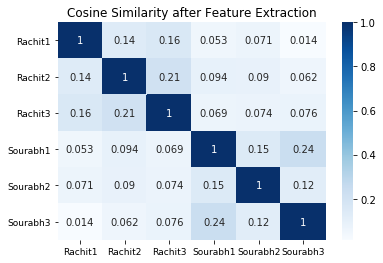

In [0]:
ax = sns.heatmap(mat,cmap="Blues",annot=True)
ax.set_yticklabels(np.array(['Rachit1','Rachit2','Rachit3','Sourabh1','Sourabh2','Sourabh3']),fontsize=9)
ax.set_xticklabels(np.array(['Rachit1','Rachit2','Rachit3','Sourabh1','Sourabh2','Sourabh3']),fontsize=9)
plt.yticks(rotation=0)
plt.title('Cosine Similarity after Feature Extraction')
plt.savefig('Cosine Similarity after Feature Extraction.png',dpi=1000,bbox_inches='tight')